In [ ]:
#!pip install pytorch-transformers

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import torch
import os
import json
import re

from sklearn.model_selection import train_test_split 
from datetime import datetime as dt
from dateutil import tz

In [6]:
@inproceedings{ott2019fairseq,
  title = {fairseq: A Fast, Extensible Toolkit for Sequence Modeling},
  author = {Myle Ott and Sergey Edunov and Alexei Baevski and Angela Fan and Sam Gross and Nathan Ng and David Grangier and Michael Auli},
  booktitle = {Proceedings of NAACL-HLT 2019: Demonstrations},
  year = {2019},
}


roberta = torch.hub.load('pytorch/fairseq', 'roberta.large', force_reload=True, pretrained=True)

Downloading: "https://github.com/pytorch/fairseq/archive/master.zip" to /home/ec2-user/.cache/torch/hub/master.zip
100%|██████████| 655283069/655283069 [00:12<00:00, 53639557.79B/s]


loading archive file http://dl.fbaipublicfiles.com/fairseq/models/roberta.large.tar.gz from cache at /home/ec2-user/.cache/torch/pytorch_fairseq/83e3a689e28e5e4696ecb0bbb05a77355444a5c8a3437e0f736d8a564e80035e.c687083d14776c1979f3f71654febb42f2bb3d9a94ff7ebdfe1ac6748dba89d2
extracting archive file /home/ec2-user/.cache/torch/pytorch_fairseq/83e3a689e28e5e4696ecb0bbb05a77355444a5c8a3437e0f736d8a564e80035e.c687083d14776c1979f3f71654febb42f2bb3d9a94ff7ebdfe1ac6748dba89d2 to temp dir /tmp/tmpck7r99uf
| dictionary: 50264 types


1042301B [00:00, 3840352.97B/s]
456318B [00:00, 8968984.34B/s]


In [9]:
csv_path = 'https://sagemaker-dadjokes.s3-us-west-2.amazonaws.com/dadjokes/data_redditdadjokes.csv'

dj = pd.read_csv(csv_path, na_values=["[deleted]", "",'N/A'], index_col=0, sep='|')
dj.head()

,createdUTC,parent_createdUTC,author,title,selftext,score,num_comments
id,,,,,,,
cwyfb2,1567070342,NaN,Adamwithan0,At first I really didn’t like my new haircut,But then it grew on me,1,0
cwyed7,1567070155,NaN,Lewwap,My girlfriend just couldn’t accept my obsessio...,In the end it Taurus apart,1,0
cwyaa7,1567069340,NaN,AffeKaffe,How do you become good at ping pong?,Just become Ching Chong,1,1
cwy7w4,1567068844,NaN,s0apyjam,Time for Golf Puns!,But whatever fore? \n\n\nA little birdie tol...,1,2
cwy5kt,1567068337,NaN,govuxyz,What do you call a place where everyone's laug...,Lol Lol Land,1,1


In [19]:
dj.isna().sum()

createdUTC                0
parent_createdUTC    158600
author                14417
title                     3
selftext              14225
score                     0
num_comments              0
is_crosspost              0
dtype: int64

In [22]:
def fill_na(df):
    df.title.fillna('', inplace=True)
    df.selftext.fillna('', inplace=True)
    return df

dj = fill_na(dj)
dj.isna().sum()

createdUTC                0
parent_createdUTC    158600
author                14417
title                     0
selftext                  0
score                     0
num_comments              0
is_crosspost              0
dtype: int64

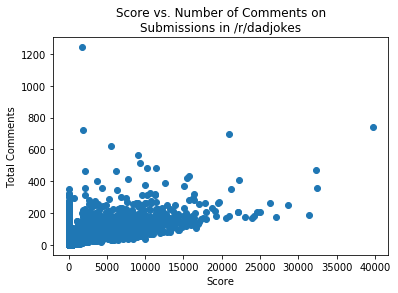

In [12]:
plt.scatter(dj.score, dj.num_comments);
plt.xlabel('Score')
plt.ylabel('Total Comments')
plt.title('Score vs. Number of Comments on\nSubmissions in /r/dadjokes')
plt.show()

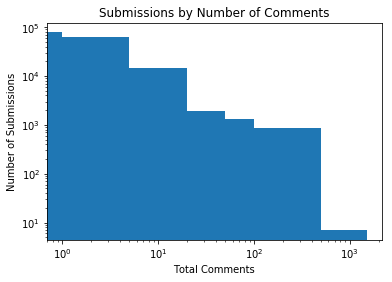

In [13]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Comments')
plt.ylabel('Number of Submissions')
plt.title('Submissions by Number of Comments')
plt.hist(dj.num_comments, bins=[0,1,5,20,50,100,500,1500]);
plt.show()

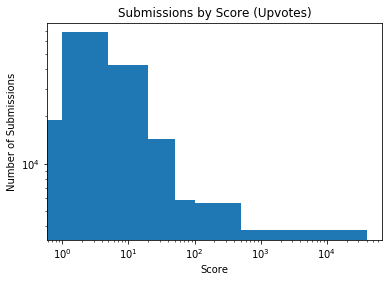

In [14]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Number of Submissions')
plt.title('Submissions by Score (Upvotes)')
plt.hist(dj.score, bins=[0,1,5,20,50,100,500,40000]);
plt.show()

In [15]:
dj['is_crosspost'] = ~dj['parent_createdUTC'].isna()
dj.groupby(by='is_crosspost').mean()    

,createdUTC,parent_createdUTC,score,num_comments
is_crosspost,,,,
False,1.494017e+09,NaN,91.560485,3.317579
True,1.544253e+09,1.543761e+09,2.565147,0.350163


##### Crossposts receive significantly lower scores, num_comments than original posts in the dadjokes subreddit. This may be because viewers are easily redirected to the parent post to comments or upvote in other areas of reddit. However, the contents of the crossposted jokes (title and selftext) are pulled from the parent posts. Therefore crossposts will be analyzed separately when attempting to predict scores, num_comments.

In [23]:
main = dj[~dj.is_crosspost].drop(columns=['parent_createdUTC', 'is_crosspost'])
main.shape

(158600, 6)

In [24]:
train, test = train_test_split(main, test_size=0.2, random_state=42)
print(f"Training sample size: {len(train)}\nTesting sample size: {len(test)}")

Training sample size: 126880
Testing sample size: 31720


In [25]:
roberta.eval()

def _rob_encode(df, col):
    df[col + '_tokens'] = df[col].apply(lambda x: roberta.encode(x))
    return df

def roberta_encode(df):
    df = _rob_encode(df, 'title')
    df = _rob_encode(df, 'selftext')
    return df

train_dj = roberta_encode(train)
train_dj.head()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,createdUTC,author,title,selftext,score,num_comments,title_tokens,selftext_tokens
id,,,,,,,,
41z15r,1453364337,NaN,Dropped this on my sister earlier,,1,0,"[tensor(0), tensor(46755), tensor(5686), tenso...","[tensor(0), tensor(2)]"
1re3ku,1385347275,laponic4,If My Child Is Ever Gay...,"If I ever have a gay son, and he tells me that...",0,0,"[tensor(0), tensor(1106), tensor(1308), tensor...","[tensor(0), tensor(1106), tensor(38), tensor(6..."
4xaseo,1470961529,macromoog,Why did the man put a steak in his water heater?,He wanted to take a meatier shower.,14,1,"[tensor(0), tensor(7608), tensor(222), tensor(...","[tensor(0), tensor(894), tensor(770), tensor(7..."
2xdca9,1425057860,All_Hail_Dionysus,My grandma just sent a chain email full of the...,'Lexophile' is a word used to describe those t...,19,1,"[tensor(0), tensor(2387), tensor(30894), tenso...","[tensor(0), tensor(108), tensor(43551), tensor..."
4aqc6r,1458169776,NaN,After getting fruit in the mail,,1,0,"[tensor(0), tensor(4993), tensor(562), tensor(...","[tensor(0), tensor(2)]"
